In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
import math
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import precision_recall_fscore_support as score

In [2]:
df=pd.read_csv("FraudTransactions.csv")
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


# Correlation Matrix and Sampling 

[Text(0.5, 1, 'Correlation Matrix')]

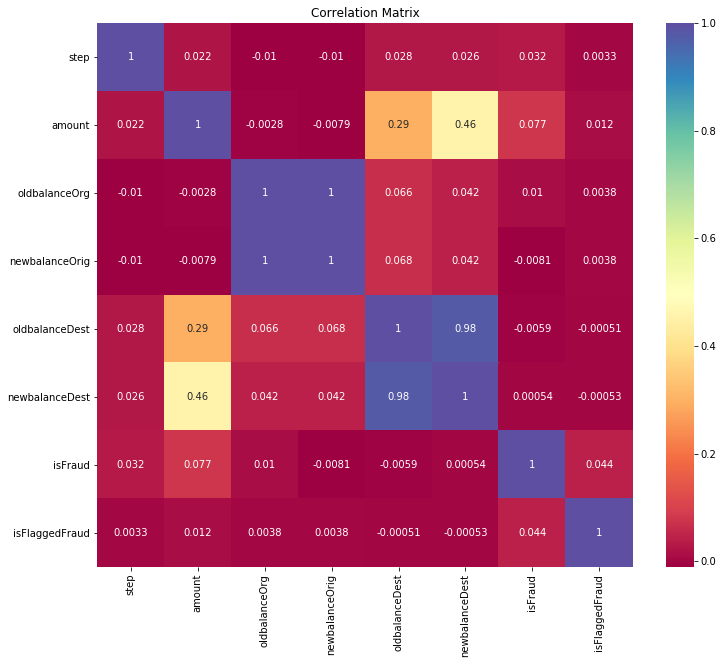

In [3]:
corr = df.corr() 
plt.figure(figsize=(12,10))
sns.heatmap(data=corr, annot=True, cmap='Spectral').set(title="Correlation Matrix")

In [4]:
#percentages of 0 and 1
print("Ratio of each possible output in the target column:")
(df['isFraud'].value_counts()/len(df))*100


Ratio of each possible output in the target column:


0    99.870918
1     0.129082
Name: isFraud, dtype: float64

In [5]:
df_new=df.sample(frac=0.02)
(df_new['isFraud'].value_counts()/len(df_new))*100 , len(df_new)

(0    99.885267
 1     0.114733
 Name: isFraud, dtype: float64,
 127252)

In [6]:
new_dff=df.drop("isFraud",axis=1)
target=df["isFraud"]
X_df, X_df_remove, y_df, y_remove = train_test_split(np.array(new_dff),np.array(target),
                                                        test_size=0.975,stratify=target)
df=pd.DataFrame(X_df, columns=df.columns.drop('isFraud'))
df=pd.concat([df,pd.Series(y_df).rename('isFraud')], axis=1)
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFlaggedFraud,isFraud
0,41,TRANSFER,494909.68,C975583086,15684.0,0.0,C1453858895,311958.31,806867.99,0,0
1,275,PAYMENT,9764.18,C2080559293,0.0,0.0,M337972713,0.0,0.0,0,0
2,133,CASH_OUT,251827.92,C1172997596,0.0,0.0,C1281270135,2158584.24,2106337.87,0,0
3,164,CASH_OUT,128310.83,C930424867,0.0,0.0,C519343215,1553258.67,1681569.49,0,0
4,40,PAYMENT,3313.12,C24830054,368178.43,364865.31,M1006775704,0.0,0.0,0,0


In [7]:
print("Check that the same ratio is maintained after sampling: ")
(df['isFraud'].value_counts()/len(df))*100 , len(df)

Check that the same ratio is maintained after sampling: 


(0    99.871122
 1     0.128878
 Name: isFraud, dtype: float64,
 159065)

train_test_split stratified is more accurate 

# Preprocessing

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159065 entries, 0 to 159064
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   step            159065 non-null  object
 1   type            159065 non-null  object
 2   amount          159065 non-null  object
 3   nameOrig        159065 non-null  object
 4   oldbalanceOrg   159065 non-null  object
 5   newbalanceOrig  159065 non-null  object
 6   nameDest        159065 non-null  object
 7   oldbalanceDest  159065 non-null  object
 8   newbalanceDest  159065 non-null  object
 9   isFlaggedFraud  159065 non-null  object
 10  isFraud         159065 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 13.3+ MB


In [9]:
print("Cardinality of column type: ",df['type'].nunique())

Cardinality of column type:  5


In [10]:
print("There are ", df['type'].nunique() , "types of transactions.")
df['type'].groupby(df['isFraud']).value_counts()

There are  5 types of transactions.


isFraud  type    
0        CASH_OUT    55732
         PAYMENT     53784
         CASH_IN     35100
         TRANSFER    13176
         DEBIT        1068
1        TRANSFER      103
         CASH_OUT      102
Name: type, dtype: int64

It seems like fraud transactions only occur from CASH_OUT and TRANSFER

We can use 1 hot encoding k-1 to make the "type" column numerical instead of categorical

In [11]:
print("Looking only at the 1st character")
print("Cardinality of column nameOrig: ", df['nameOrig'].str[:1].nunique())
print("Cardinality of column nameDest: ", df['nameDest'].str[:1].nunique())

Looking only at the 1st character
Cardinality of column nameOrig:  1
Cardinality of column nameDest:  2


There is only one letter in nameOrig, doesn't affect the output
The first letter in "nameDest" might be related to the output

In [12]:
df['nameDest_reduced']=df['nameDest'].str[:1]
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFlaggedFraud,isFraud,nameDest_reduced
0,41,TRANSFER,494909.68,C975583086,15684.0,0.0,C1453858895,311958.31,806867.99,0,0,C
1,275,PAYMENT,9764.18,C2080559293,0.0,0.0,M337972713,0.0,0.0,0,0,M
2,133,CASH_OUT,251827.92,C1172997596,0.0,0.0,C1281270135,2158584.24,2106337.87,0,0,C
3,164,CASH_OUT,128310.83,C930424867,0.0,0.0,C519343215,1553258.67,1681569.49,0,0,C
4,40,PAYMENT,3313.12,C24830054,368178.43,364865.31,M1006775704,0.0,0.0,0,0,M


In [13]:
df["isFraud"].value_counts()

0    158860
1       205
Name: isFraud, dtype: int64

In [14]:
#df['nameDest_reduced'].groupby(df['isFraud']).value_counts()
only1=df[df["isFraud"]==1]
only1["nameDest_reduced"].groupby(only1['isFraud']).value_counts()


isFraud  nameDest_reduced
1        C                   205
Name: nameDest_reduced, dtype: int64

ALL Fraud Transaction occur when recipient of the transaction 'nameDest'= C

# Apply one hot encoding on "type" and "nameDest_reduced" columns

In [15]:
new_df=df.drop(["nameOrig","nameDest"], axis=1)
new_df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,isFraud,nameDest_reduced
0,41,TRANSFER,494909.68,15684.0,0.0,311958.31,806867.99,0,0,C
1,275,PAYMENT,9764.18,0.0,0.0,0.0,0.0,0,0,M
2,133,CASH_OUT,251827.92,0.0,0.0,2158584.24,2106337.87,0,0,C
3,164,CASH_OUT,128310.83,0.0,0.0,1553258.67,1681569.49,0,0,C
4,40,PAYMENT,3313.12,368178.43,364865.31,0.0,0.0,0,0,M


In [16]:
type_dummy=pd.get_dummies(new_df['type'],drop_first=True)
type_dummy.head()

,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,0,0,0,1
1,0,0,1,0
2,1,0,0,0
3,1,0,0,0
4,0,0,1,0


In [17]:
Dest_dummy=pd.get_dummies(new_df['nameDest_reduced'],drop_first=True)
Dest_dummy.head()

,M
0,0
1,1
2,0
3,0
4,1


In [18]:
NumericalDataset = pd.concat([new_df,type_dummy],axis=1)
NumericalDataset = pd.concat([NumericalDataset,Dest_dummy],axis=1)
NumericalDataset.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,isFraud,nameDest_reduced,CASH_OUT,DEBIT,PAYMENT,TRANSFER,M
0,41,TRANSFER,494909.68,15684.0,0.0,311958.31,806867.99,0,0,C,0,0,0,1,0
1,275,PAYMENT,9764.18,0.0,0.0,0.0,0.0,0,0,M,0,0,1,0,1
2,133,CASH_OUT,251827.92,0.0,0.0,2158584.24,2106337.87,0,0,C,1,0,0,0,0
3,164,CASH_OUT,128310.83,0.0,0.0,1553258.67,1681569.49,0,0,C,1,0,0,0,0
4,40,PAYMENT,3313.12,368178.43,364865.31,0.0,0.0,0,0,M,0,0,1,0,1


In [19]:
NumericalDataset=NumericalDataset.drop(["type","nameDest_reduced"], axis=1)
NumericalDataset.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,isFraud,CASH_OUT,DEBIT,PAYMENT,TRANSFER,M
0,41,494909.68,15684.0,0.0,311958.31,806867.99,0,0,0,0,0,1,0
1,275,9764.18,0.0,0.0,0.0,0.0,0,0,0,0,1,0,1
2,133,251827.92,0.0,0.0,2158584.24,2106337.87,0,0,1,0,0,0,0
3,164,128310.83,0.0,0.0,1553258.67,1681569.49,0,0,1,0,0,0,0
4,40,3313.12,368178.43,364865.31,0.0,0.0,0,0,0,0,1,0,1


In [20]:
NumericalDataset.dtypes

step              object
amount            object
oldbalanceOrg     object
newbalanceOrig    object
oldbalanceDest    object
newbalanceDest    object
isFlaggedFraud    object
isFraud            int64
CASH_OUT           uint8
DEBIT              uint8
PAYMENT            uint8
TRANSFER           uint8
M                  uint8
dtype: object

# Normalize Data and Apply PCA

In [21]:
train_set=NumericalDataset.drop("isFraud", axis=1)
scaler = preprocessing.StandardScaler().fit(train_set)
train_data = pd.DataFrame(scaler.transform(train_set),columns=train_set.columns)
#dataset_scaled
#train_data=dataset_scaled
test_data=NumericalDataset["isFraud"]
train_data.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,CASH_OUT,DEBIT,PAYMENT,TRANSFER,M
0,-1.420090,0.512982,-0.284858,-0.294074,-0.235210,-0.114394,-0.003546,-0.735435,-0.082217,-0.714746,3.313410,-0.714746
1,0.225614,-0.272270,-0.290308,-0.294074,-0.327872,-0.334650,-0.003546,-0.735435,-0.082217,1.399099,-0.301804,1.399099
2,-0.773061,0.119532,-0.290308,-0.294074,0.313294,0.240329,-0.003546,1.359739,-0.082217,-0.714746,-0.301804,-0.714746
3,-0.555040,-0.080391,-0.290308,-0.294074,0.133494,0.124378,-0.003546,1.359739,-0.082217,-0.714746,-0.301804,-0.714746
4,-1.427123,-0.282712,-0.162385,-0.168876,-0.327872,-0.334650,-0.003546,-0.735435,-0.082217,1.399099,-0.301804,1.399099


In [22]:
from sklearn.decomposition import PCA
pca = PCA(n_components="mle", whiten=True,svd_solver ="full").fit(train_data)
train_data=pca.transform(train_data)
print("New Dimension of Train_data after PCA: ", len(train_data[0]))


New Dimension of Train_data after PCA:  11


## CREATE THE MODEL

# 1- Poly Kernel

In [23]:
def plot(recall_folds,penalty,degree):
    plt.figure()
    plt.plot(range(1,len(recall_folds)+1),recall_folds)
    plt.ylabel("Recall")
    plt.xlabel("Folds")
    plt.title("Polynomial degree: "+ str(degree) + ", Regularization (C) = "+ str(penalty))

In [24]:
def regularization(best_Xtrain_model,best_Ytrain_model,best_Xcross_model,best_Ycross_model,i):
    c=np.linspace(0.5, 1.0, num=15)
    max_Recall=[]
    for z in c:
            model = SVC(kernel='poly', C=z, degree=i)
            model.fit(best_Xtrain_model,best_Ytrain_model)
            y_pred_cross=model.predict(best_Xcross_model)
            precision,recall,fscore,support=score(best_Ycross_model,y_pred_cross,average='macro')
            max_Recall.append(recall)
    best_parameter=c[max_Recall.index(max(max_Recall))]
    best_recall=max(max_Recall)
    return best_recall,best_parameter

In [25]:
def SVM():
    X_train_cross, X_test, y_train_cross, y_test = train_test_split(train_data,np.array(test_data),
                                                        test_size=0.25,stratify=test_data)

    print(len(X_train_cross))
 
    #cv = KFold(n_splits=5,shuffle=True)
    cv=StratifiedKFold(n_splits=5,shuffle=True)
    # create model
    max_recall=0
    cross_err_poly=[]
    penalties=[]
    for i in range(1,6):
        #print("degree= ", i)
        #cross_err_poly=[]
        recall_folds=[]
        z=0
        #for train_index, test_index in cv.split(X_train_cross):
        for train_index, test_index in cv.split(X_train_cross,y_train_cross):
            #print("count=", z)
            z+=1
            X_train, X_cross = X_train_cross[train_index], X_train_cross[test_index]
            y_train, y_cross = y_train_cross[train_index], y_train_cross[test_index]
            
            model = SVC(kernel='poly', degree=i)
            model.fit(X_train, y_train)
            #print("TRAIN:", train_index, "TEST:", test_index)

            y_pred_cross=model.predict(X_cross)
            y_pred_train=model.predict(X_train)
          
            precision,recall,fscore,support=score(y_cross,y_pred_cross,average='macro')
            recall_folds.append(recall)

            if recall>max_recall:
                max_recall=recall
                best_Xtrain_model=X_train
                best_Ytrain_model=y_train
                best_Xcross_model=X_cross
                best_Ycross_model=y_cross
            
        max_recall,penalty=regularization(best_Xtrain_model,best_Ytrain_model,best_Xcross_model,best_Ycross_model,i)
        cross_err_poly.append(max_recall)
        penalties.append(penalty)
        
        plot( recall_folds,penalty,i)
        
    Max_Recall= max(cross_err_poly)  
    Best_polynomial_degree= cross_err_poly.index(max(cross_err_poly))+1
    Best_penalty=penalties[cross_err_poly.index(max(cross_err_poly))]
    return Best_polynomial_degree,Max_Recall,Best_penalty,best_Xtrain_model,best_Ytrain_model,X_test,y_test

    
    

# Cross Validation Recall

119298


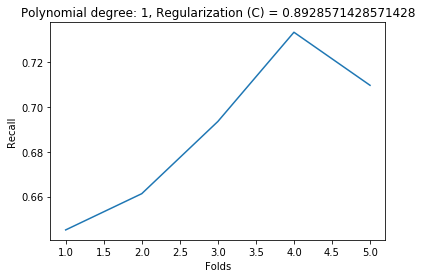

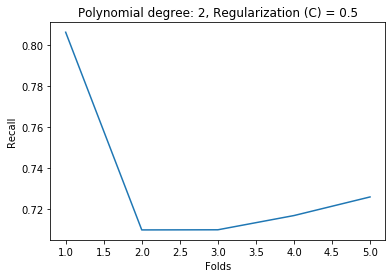

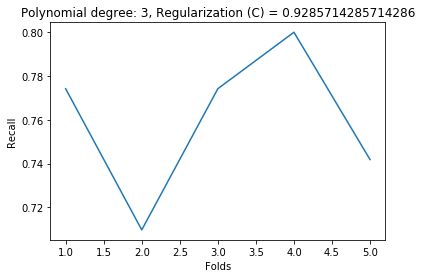

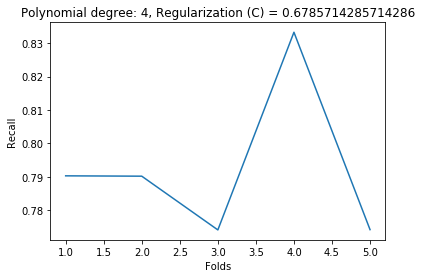

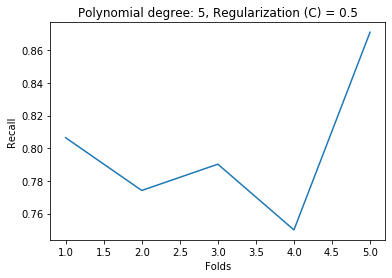

In [26]:
Best_polynomial_degree,MaxRecall,penalty,best_Xtrain_model,best_Ytrain_model,X_test,y_test=SVM()


In [27]:
print("Best polynomial degree: " + str(Best_polynomial_degree) + ", with recall = " + str(MaxRecall)  + ", at reg c= " + str(penalty))

Best polynomial degree: 5, with recall = 0.8709677419354839, at reg c= 0.5


# Test Model with the test data

In [28]:
def test(Best_polynomial_degree,penalty,best_Xtrain_model,best_Ytrain_model, X_test,y_test):
    model = SVC(kernel='poly', degree=Best_polynomial_degree, C=penalty)
    model.fit(best_Xtrain_model,best_Ytrain_model)
    y_pred_test=model.predict(X_test)
    precision,recall,fscore,support=score(y_test,y_pred_test,average='macro')
    #print("hi", y_test.sum())
    return recall

    

In [30]:
recall_test=test(Best_polynomial_degree,penalty,best_Xtrain_model,best_Ytrain_model, X_test,y_test)
print("Recall of test data= " + str(recall_test))

Recall of test data= 0.7843011361055652


In [ ]:
#print(classification_report(y_train,y_pred_train))
#penalty=["l1", "l2", "elasticnet", "none"]

# 2-  Aplly kernels: linear, sigmoid, rbf

In [31]:
def RegularizationKernels(best_Xtrain_model,best_Ytrain_model,best_Xcross_model,best_Ycross_model,i):
    c=np.linspace(0.6, 1.0, num=20)
    max_Recall=[]
    for z in c:
            model = SVC(kernel=i, C=z)
            model.fit(best_Xtrain_model,best_Ytrain_model)
            y_pred_cross=model.predict(best_Xcross_model)
            precision,recall,fscore,support=score(best_Ycross_model,y_pred_cross,average='macro')
            max_Recall.append(recall)
    best_parameter=c[max_Recall.index(max(max_Recall))]
    best_recall=max(max_Recall)
    return best_recall,best_parameter

In [32]:
def plotKernel(recall_folds,penalty,kernel):
    plt.figure()
    plt.plot(range(1,len(recall_folds)+1),recall_folds)
    plt.ylabel("Recall")
    plt.xlabel("Folds")
    plt.title("Kernel: "+ kernel + ", Regularization (C) = "+ str(penalty))

In [33]:
def SVM_Kernels():
    X_train_cross, X_test, y_train_cross, y_test = train_test_split(train_data,np.array(test_data),
                                                        test_size=0.2,stratify=test_data)


    kernels=['linear','sigmoid','rbf'] 
    #cv =KFold(n_splits=5,shuffle=True)
    cv =StratifiedKFold(n_splits=5,shuffle=True)
    # create model
    max_recall=0
    cross_err_kernels=[]
    penalties=[]
    for i in kernels:
        
        #cross_err_poly=[]
        recall_folds=[]
        z=0
        #for train_index, test_index in cv.split(X_train_cross):
        for train_index, test_index in cv.split(X_train_cross,y_train_cross):
           # print("count=", z)
            z+=1
            X_train, X_cross = X_train_cross[train_index], X_train_cross[test_index]
            y_train, y_cross = y_train_cross[train_index], y_train_cross[test_index]
            
            model = SVC(kernel=i)
            model.fit(X_train, y_train)
            #print("TRAIN:", train_index, "TEST:", test_index)

            y_pred_cross=model.predict(X_cross)
            #y_pred_train=model.predict(X_train)
          
            precision,recall,fscore,support=score(y_cross,y_pred_cross,average='macro')

            recall_folds.append(recall)

            if recall>max_recall:
                max_recall=recall
                best_Xtrain_model=X_train
                best_Ytrain_model=y_train
                best_Xcross_model=X_cross
                best_Ycross_model=y_cross
            
        max_recall,penalty=RegularizationKernels(best_Xtrain_model,best_Ytrain_model,best_Xcross_model,best_Ycross_model,i)
        cross_err_kernels.append(max_recall)
        penalties.append(penalty)
        
        plotKernel( recall_folds,penalty,i)
        
    Max_Recall=max(cross_err_kernels)
    Best_Kernel= kernels[cross_err_kernels.index(max(cross_err_kernels))]
    Best_penalty=penalties[cross_err_kernels.index(max(cross_err_kernels))]
    return Best_Kernel,Max_Recall,Best_penalty,best_Xtrain_model,best_Ytrain_model,X_test,y_test


# Cross Validation recall

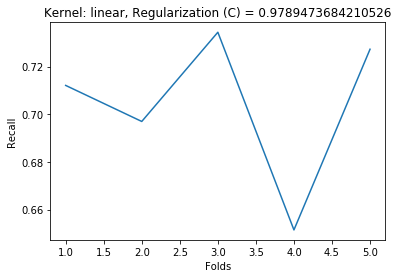

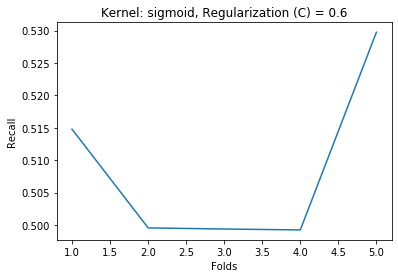

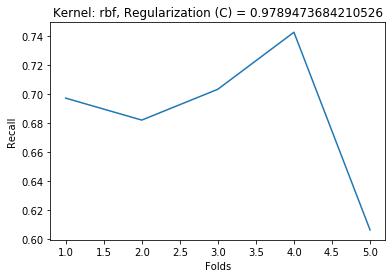

In [34]:
Best_Kernel,MaxRecall,penalty,best_Xtrain_model,best_Ytrain_model,X_test,y_test=SVM_Kernels()

In [35]:
Best_Kernel,MaxRecall,penalty

print("Best Kernel: " + Best_Kernel + ", with recall = " + str(MaxRecall)  + ", at reg c= " + str(penalty))




Best Kernel: rbf, with recall = 0.7424242424242424, at reg c= 0.9789473684210526


# Test the Model

In [36]:
def testKernels(Best_Kernel,penalty,best_Xtrain_model,best_Ytrain_model, X_test,y_test):
    model = SVC(kernel= Best_Kernel, C=penalty)
    model.fit(best_Xtrain_model,best_Ytrain_model)
    y_pred_test=model.predict(X_test)
    precision,recall,fscore,support=score(y_test,y_pred_test,average='macro')
    #print("hi", y_test.sum())
    return recall


In [38]:
recall_test=testKernels(Best_Kernel,penalty,best_Xtrain_model,best_Ytrain_model, X_test,y_test)
print("Recall of test data= " + str(recall_test))

Recall of test data= 0.6829268292682926


# Conclusion